<a href="https://colab.research.google.com/github/xpertdesh/ml-class21/blob/main/labs/deepLearningNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Deep Learning for Natural Language Processing

Natural Language Processing (NLP) covers machine learning techniques dealing with text and includes

* classification
  * sentiment analyis (is this tweet a Pro-Biden or Anti-Biden one)
  * stylometrics (was this typed suicide note really from the deceased or did the murderer write it [1](https://www.rosette.com/case-studies/alias/), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3107011/)
  * general classification (out of 40 topics, which is this article about)
* question answering (building systems that can answer questions -- *What is the best treatment for hemangiosarcoma in dogs?*)
* machine translation
* speech recognition

among many others. Deep Learning has led to tremendous improvements in all these areas of NLP. 

In this notebook, we are going to examine classification systems for textual information.





## Analyzing and Classifying Text



<img src="https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/tiles.jpg" width="500"/>

So far we have been dealing with **structured data**. Structured data is ... well ... structured. This means that an instance of our data has nice attributes that can be represented in a DataFrame or a table:

make | mpg | cylinders | HP | 0-60 |
---- | :---: | :---: | :---: | :---: |
Fiat | 38 | 4 | 157   | 6.9 
Ford F150 | 19 | 6 | 386 | 6.3 
Mazda 3 | 37 | 4 | 155 |  7.5 
Ford Escape | 27 | 4 | 245 | 7.1 
Kia Soul | 31 | 4 | 164 | 8.5 

The majority of data in the world is **unstructured**. Take text for example. Suppose I have a corpus of twitter posts from President Trump and the Dalai Lama and my goal is to create a classifier that takes a tweet and tells me if it was produced by Trump or the Dalai Lama:

*The purpose of education is to build a happier society, we need a more holistic approach that promotes the practice of love and compassion.*

*How low has President Obama gone to tapp my phones during the very sacred election*

We might consider  the columns of a table to be things like *first word of the tweet*, *second word of the tweet* and so on:


id | word 1 | word 2 | word 3 | word 4 |word 5 |word 6 | ... |
---- | :---: | :---: | :---: | :---: | :---: |:---: |:---: |
1 | The | purpose | of   | education |is | to | ...
2 | How | low | has |President | Obama | gone | ...

So we would be counting how many times the word *President* occurred as the fourth word of a tweet. **But that would be the wrong way to go**. First, the deep learning models we have developed so far require input of a specific length. For example, we resized our dog and cat images to a uniform 150x150 and because each image was a uniform size we could specify the input shape of our network to be ....

```
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
```

But what should the input length be for tweets? Sometimes there are short, one-word, tweets like *nice*. The average length of a tweet is 30 characters so something like the six word *Today, Toaster is 10 years old.*  And the limit of course is 280 characters so...

> Like anything else, life has a beginning and in due course must end. In between those two events the important goal should be to live meaningfully, not to create trouble for others. If we can do that, when the end comes, we can go feeling at peace.

That's 47 words so maybe we can limit our input to 50 words and for shorter tweets we can pad them with blank words.  But there is another possibility ...

### Bag of Words (bow)

A more common way to represent text is to treat the text as an unordered set of words, which is called the **bag of words** approach. 


<img src="http://zacharski.org/files/courses/cs419/BagofWords.jpg" width="350"/>

With the bag of words approach we count word occurrences and the features (what we might think of as columns) are the unique words. For example, we have a collection of Trump and Dalai Lama tweets and indicate whether the word occurred in the tweet or not. So we might get something like:

id | a | the | compassion | love |sad |fake | rigged | ... |
---- | :---: | :---: | :---: | :---: | :---: |:---: |:---: | :---:
Trump_1 | 1 | 0 | 0   | 0 |1 | 1 | 1 |...
Trump_2 | 1 | 1 | 0   | 0 | 0 | 1 | 1 |...
DalaiLama_1 | 1 | 1 | 1 |1 | 0 | 0 | 0 | ...

So, for example, in DalaiLama_1, in the text there was

* an occurrence of *a*
* an occurrence of *the*
* an occurrence of *compassion*
* an occurrence of *love*

We don't know what order the words occurred in, we just know what words occurred in the tweet. This is the bag-of-words method. 

Instead of short text snippets like tweets, let's say we are analyzing speeches of Trump and the Dalai Lama. Maybe then we will count how many times they used each word. So something like:

id | a | the | compassion | love |sad |fake | rigged | ... |
---- | :---: | :---: | :---: | :---: | :---: |:---: |:---: | :---:
Trump_1 | 52 | 25 | 0   | 0 |21 | 82 | 19 |...
Trump_2 | 30 | 35 | 0   | 0 | 5 | 20 | 31 |...
DalaiLama_1 | 60 | 271 | 27 |63 | 12 | 0 | 0 | ...

Of course we are still faced with how many columns to make, representing the vocabulary size. We could limit it to the 10,000 most common words, for example.

Once we have the text in this format we can use the standard deep learning classification techniques we used before.


Converting **unstructured** text to something **structured** is a multistep process. Let's learn the bits before putting it together. And we will start with the last step first-- creating the bag of words.

### Import Keras ...



In [ ]:
import keras
keras.__version__

'2.4.3'

### Some sample data

In [ ]:
trump1 = "How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Obama bad (or sick) guy! Sad"
trump2 = "Our wonderful new Healthcare Bill is now out for review and negotiation. ObamaCare is a complete and total disaster - is imploding fast! Sad"
trump3 = "Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!"
trump4 = "Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks! Sad"
dalaiLama1 = "The purpose of education is to build a happier society, we need a more holistic approach that promotes the practice of love and compassion."
dalaiLama2 = "Be a kind and compassionate person. This is the inner beauty that is a key factor to making a better world."
dalaiLama3 = "If our goal is a happier, more peaceful world in the future, only education will bring change."
dalaiLama4 = "Love and compassion are important, because they strengthen us. This is a source of hope"
tinyCorpus = [trump1, trump2, trump3, trump4, dalaiLama1, dalaiLama2, dalaiLama3, dalaiLama4]
tinyCorpus

['How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Obama bad (or sick) guy! Sad',
 'Our wonderful new Healthcare Bill is now out for review and negotiation. ObamaCare is a complete and total disaster - is imploding fast! Sad',
 "Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!",
 'Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks! Sad',
 'The purpose of education is to build a happier society, we need a more holistic approach that promotes the practice of love and compassion.',
 'Be a kind and compassionate person. This is the inner beauty that is a key factor to making a better world.',
 'If our goal is a happier, more peaceful world in the future, only education will bring change.',
 'Love and compassion are important, because they strengthe

### Create the bag of words

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(tinyCorpus)

# Directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(tinyCorpus, mode='binary')
# let's look at an example of an encoding ...
print(one_hot_results[0])


# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

[0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Found 117 unique tokens.


In [ ]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

That was pretty easy. And now we have the texts in a form we can use for deep learning.

Instead of the binary choice (a 1 if the word is present and a 0 if not) -- `mode='binary'` we can count how many occurrences of each word there were in the text:


In [ ]:
one_hot_results = tokenizer.texts_to_matrix(tinyCorpus, mode='count')
# let's look at an example of an encoding ...
print(one_hot_results[1])

[0. 0. 3. 2. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


So in the first tweet:

> 'Our wonderful new Healthcare Bill is now out for review and negotiation. ObamaCare is a complete and total disaster - is imploding fast! Sad',

There were 3 occurrences of the word *is*, 2 of *and*, and so on as indicated in the first row above.

How do we know what columns are associated with which words? We can use the word_index.



In [ ]:
# tokenizer.word_index is a python dictionary containing the word as a key and the column as its value
[(k, v) for k, v in sorted(tokenizer.word_index.items(), key=lambda item: item[1])]

[('the', 1),
 ('is', 2),
 ('and', 3),
 ('a', 4),
 ('to', 5),
 ('this', 6),
 ('sad', 7),
 ('that', 8),
 ('in', 9),
 ('of', 10),
 ('obama', 11),
 ('election', 12),
 ('our', 13),
 ('out', 14),
 ('fake', 15),
 ('news', 16),
 ('big', 17),
 ('we', 18),
 ('are', 19),
 ('getting', 20),
 ('by', 21),
 ('education', 22),
 ('happier', 23),
 ('more', 24),
 ('love', 25),
 ('compassion', 26),
 ('world', 27),
 ('how', 28),
 ('low', 29),
 ('has', 30),
 ('president', 31),
 ('gone', 32),
 ('tapp', 33),
 ('my', 34),
 ('phones', 35),
 ('during', 36),
 ('very', 37),
 ('sacred', 38),
 ('process', 39),
 ('nixon', 40),
 ('watergate', 41),
 ('bad', 42),
 ('or', 43),
 ('sick', 44),
 ('guy', 45),
 ('wonderful', 46),
 ('new', 47),
 ('healthcare', 48),
 ('bill', 49),
 ('now', 50),
 ('for', 51),
 ('review', 52),
 ('negotiation', 53),
 ('obamacare', 54),
 ('complete', 55),
 ('total', 56),
 ('disaster', 57),
 ('imploding', 58),
 ('fast', 59),
 ("don't", 60),
 ('let', 61),
 ('tell', 62),
 ('you', 63),
 ('there', 64),
 

So, *the, is, and, a, to* are the words represented by the first five columns.


# TF-IDF representation
So far we looked at 

* a binary bag-of-words (whether or not the word was present in the text).
* a raw count bag-of-words (counting how many occurrences of each word)

There are several other approaches
We could represent a document as a bag of words and their probabilities (`mode="freq"`). For example, in *Tom Sawyer* 4.6% of the words are *the* and 0.95% are *Tom*. But the word *the* probably occurs in most novels with that frequency. So in some sense the word *the* is uninteresting. On the other hand *Tom* probably occurs much more frequently in *Tom Sawyer* than it does in *Moby Dick* and, in that way, it is a more interesting word. One way to discount words that occur evenly throughout our document collection is to use TF-IDF.  

* TF: Term Frequency - each word uprated by how often the word occurs in the document.
* IDF Inverse Document Frequency - how often the word appears in the entire corpus

and the formula is

### $$ tfidf(t, d) = tf(t,d) \times idf(t) $$

where *t* is the term (the word) and *d* is the document.

To explain this I will use some made up data--the word counts of 5 emails (and for the sake of later computations let's assume that each email is 100 words long):

id | the | sad | compassion |  
----: | :---: | :---: | :---:
1 | 3 | 0 | 1 
2 | 3 | 0 | 0 
3 | 4 | 0 | 0 
4 | 3 | 2 | 0 
5 | 3 | 0 | 2


The intuition is this. Even though the word *the* occurs frequently in each email, it is unlikely to help us classify email because it occurs in **every** email. The words *sad* and *compassion* are more interesting as they don't occur uniformly in our collection. 

#### TF

The TF part of TF-IDF refers to how often the word occurs in the document. There are a number of ways to define TF. The simplist is to use the raw count.  So for example, the TF of *the* in document 1 is 3 (the word *the* occurred 3 times in document 1). One problem with this approach is that the raw count is influenced by the length of the document. So if you in your 1,000 word essay on Tom Sachs use 50 occurrences of *the* and I in my 90,000 word Zen van life mystery novel use 4,5000 occurrences of *the*, it doesn't mean that I am a bigger fan of *the* than you are. Even though there is that disparity in the raw counts it is not a characteristic that will help us distinguish texts about Zen from those about Tom Sachs.  In both the 1,000 word essay and the 90,000 word book about 5% of the words are *the*. A popular measure of TF is to divide the number of occurrences of a word by the total words in the document. So the TF of the word *the* in both your 1,000 word essay and my novel would be .05




#### IDF

IDF is defined as:

### $$ idf(t)=\log\frac{1+n_d}{1+df(d,t)}+ 1 $$

$n_d$ is the total number of documents and $df(d,t)$ is how many documents the term *t* occurred in. 

So:

### $$ idf(the)=\log\frac{1+5}{1+5}+ 1 =  1.5 $$

### $$ idf(compassion)=\log\frac{1+5}{1+2}+ 1 = \log{2} + 1 =  2 $$

So, *the* in document 1 has a tf-idf of $.03 \times 1.5 = 0.045$ and *compassion* has a tf-idf of $.01 \times \ 2 = 0.02$

This is a fairly important concept to understand. I was asked about tf-idf in my oral exam to become a certified instructor at the Deep Learning Institute and fortunately I knew about it. 

It is also important to know that while it works well as a heuristic and has been around since the 70s, there really is no theoretical foundation to it. 

With all that as background, it is easy to convert a document collection into an array of TFIDF values:

In [ ]:
one_hot_results = tokenizer.texts_to_matrix(tinyCorpus, mode='tfidf')
# let's look at an example of an encoding ...
print(one_hot_results[1])

[0.         0.         1.33469384 1.29041528 0.84729786 0.
 0.         1.09861229 0.         0.         0.         0.
 0.         1.29928298 1.29928298 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.60943791 1.60943791
 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791
 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791 1.60943791
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

Again, once we have this representation we can use the deep learning methods we already used.


## An initial example - IMDB

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/imdb.png)

The Internet Movie DataBase contains 50,000 movie reviews -- 25,000 in training and 25,000 in  testing. It contains an equal number of positive and negative reviews. The task of identifying the affect of a text (whether it is postive or negative, or how strongly someone feels about the topic) is called **sentiment analysis**. 

### Load the data

In [64]:
!wget http://zacharski.org/files/courses/cs419/imdb.zip
!unzip imdb.zip

--2021-04-13 18:28:51--  http://zacharski.org/files/courses/cs419/imdb.zip
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26559010 (25M) [application/zip]
Saving to: ‘imdb.zip’

imdb.zip            100%[===================>]  25.33M  84.4MB/s    in 0.3s    

2021-04-13 18:28:51 (84.4 MB/s) - ‘imdb.zip’ saved [26559010/26559010]

Archive:  imdb.zip
  inflating: imdb.csv                


In [ ]:
!ls -l

total 90608
-rw-r--r-- 1 root root 66212309 Oct 31 18:01 imdb.csv
-rw-r--r-- 1 root root 26559010 Oct 31 18:07 imdb.zip
drwxr-xr-x 1 root root     4096 Apr  7 13:36 sample_data


In [65]:
import pandas as pd
data = pd.read_csv('imdb.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Now let's separate the texts from the labels. Also note that the labels are the strings *positive* and *negative* so let's convert those to 1 and 0.

In [66]:
data_text = data.review
data_label = data.sentiment
data_label =  data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
data_label 

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

### TFIDF
Now we are going to convert the text represented as strings to a tfidf representation. 

Let's use the 5,000 most common words in the documents (`Tokenizer(num_words=5000)`)

This will take a bit of time!

In [67]:
data_text.shape

(50000,)

In [68]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_text)

# Directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(data_text, mode='tfidf')
# let's look at an example of an encoding ...
print(one_hot_results[0])

[0.         2.63159248 1.98374445 ... 0.         0.         0.        ]


In [69]:
one_hot_results.shape

(50000, 5000)

###  Divide into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split
imdb_train_text, imdb_test_text, imdb_train_labels, imdb_test_labels = train_test_split(one_hot_results, data_label, test_size = 0.2, random_state=42)
imdb_test_labels


33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: sentiment, Length: 10000, dtype: int64

### Build a deep learning model
Let's go with a basic, no frills, model:

In [ ]:
import keras
keras.__version__

'2.4.3'

In our tokenizer we specified a vocabulary size of 5,000 words, so that is our `input_shape`. We are trying to predict a binary 1,0 classification so we need 

```
network.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(5000,)))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

Again, we are predicting a binary 1,0 classification (was it a positive review or not) so we will use `binary_crossentropy` as our loss function

In [ ]:
from keras import optimizers
network.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2560512   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,724,865
Trainable params: 2,724,865
Non-trainable params: 0
_________________________________________________________________


### fitting to the data
Now it is time to fit the network to the data. Let's use 20% of the data for validation and run for 30 epochs.

In [ ]:
history = network.fit(
      imdb_train_text, imdb_train_labels,
      steps_per_epoch=100,
      epochs=30,
      validation_split=0.2,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 4s 10ms/step - loss: 0.5333 - accuracy: 0.7371 - val_loss: 0.3115 - val_accuracy: 0.8791
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2296 - accuracy: 0.9148 - val_loss: 0.2927 - val_accuracy: 0.8886
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.1536 - accuracy: 0.9479 - val_loss: 0.3293 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0982 - accuracy: 0.9704 - val_loss: 0.3426 - val_accuracy: 0.8827
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0605 - accuracy: 0.9838 - val_loss: 0.3929 - val_accuracy: 0.8810
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0348 - accuracy: 0.9924 - val_loss: 0.4902 - val_accuracy: 0.8795
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0152 - accuracy: 0.9974 - val_loss: 0.5659 - val_accuracy: 0.8791
Epoch

### Our accuracy and loss
Let's plot out both the training and validation accuracy and loss.

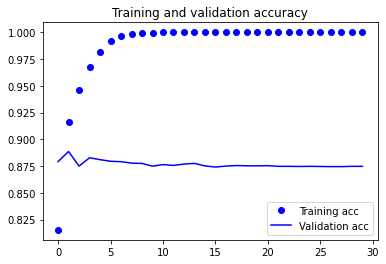

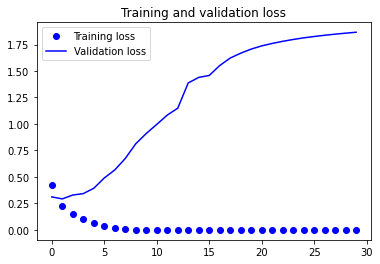

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

What is your interpretation of the plots?

.

.

.


Okay, that definitely looks like overfitting. We will examine ways of ameliorating overfitting shortly.  

Let's see how our network performs on the test data

In [ ]:
scoreSeg = network.evaluate(imdb_test_text, imdb_test_labels)
print("Accuracy: ", scoreSeg[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.8095 - accuracy: 0.8744
Accuracy:  0.8744000196456909


Not bad for our first attempt at text classification!!!

## You try - Reuters Dataset

The Reuters Dataset is another well-known machine learning dataset. The dataset consists of text from the Reuters newswire in 1987. We will use a subset of the data that contain texts from eight topics:



Class | 	# train docs |	# test docs	| Total # docs
:--- | --: | --: | --:
acq |	1596	| 696	| 2292
crude | 	253 | 	121 |	374
earn	| 2840	| 1083	| 3923
grain	|41 | 	10 | 	51
interest | 	190	| 81	| 271
money-fx	| 206	| 87	| 293
ship	| 108	| 36	| 144
trade	| 251	| 75	| 326
Total	| 5485 |	2189	| 7674

The training dataset is http://zacharski.org/files/courses/cs419/r8-train-all-terms.txt

The test dataset is http://zacharski.org/files/courses/cs419/r8-test-all-terms.txt

Can you build a network that will classify texts into one of 8 categories?





In [93]:
import pandas as pd
train = pd.read_csv('http://zacharski.org/files/courses/cs419/r8-train-all-terms.txt', sep='\t')
test = pd.read_csv('http://zacharski.org/files/courses/cs419/r8-test-all-terms.txt', sep='\t')

In [94]:
train_text = train.drop('class', axis=1).to_numpy().reshape(-1)
train_labels = train['class'].to_numpy().reshape(-1, 1)
test_text = test.drop('class', axis=1).to_numpy().reshape(-1)
test_labels = test['class'].to_numpy().reshape(-1, 1)

In [95]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.fit_transform(test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [97]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [98]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(train_text)
X_train = tokenizer.texts_to_matrix(train_text, mode='tfidf')

tokenizer2 = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(test_text)
X_test = tokenizer.texts_to_matrix(test_text, mode='tfidf')

In [100]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(1500,)))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(8, activation='softmax'))

In [101]:
from keras import optimizers
network.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [102]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               768512    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 1032      
Total params: 933,768
Trainable params: 933,768
Non-trainable params: 0
_________________________________________________________________


In [104]:
history = network.fit(
      X_train, y_train,
      steps_per_epoch=100,
      epochs=30,
      validation_split=0.2,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 2s 16ms/step - loss: 0.4921 - accuracy: 0.4841 - val_loss: 0.1746 - val_accuracy: 0.7767
Epoch 2/30
100/100 [==============================] - 1s 14ms/step - loss: 0.1096 - accuracy: 0.8941 - val_loss: 0.0959 - val_accuracy: 0.8642
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0464 - accuracy: 0.9577 - val_loss: 0.0690 - val_accuracy: 0.9189
Epoch 4/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0268 - accuracy: 0.9836 - val_loss: 0.0594 - val_accuracy: 0.9353
Epoch 5/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0167 - accuracy: 0.9880 - val_loss: 0.0492 - val_accuracy: 0.9490
Epoch 6/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0103 - accuracy: 0.9937 - val_loss: 0.0509 - val_accuracy: 0.9490
Epoch 7/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0071 - accuracy: 0.9956 - val_loss: 0.0497 - val_accuracy: 0.9553

Let's plot the results

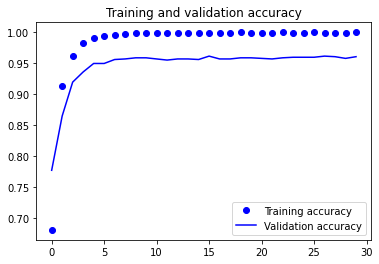

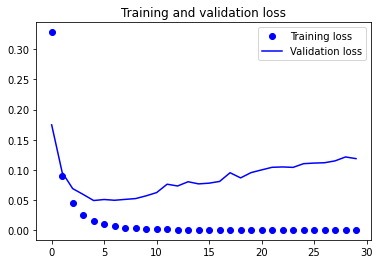

In [105]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Overfitting for both. However, the validation accuracy is not so far off.

In [106]:
scoreSeg = network.evaluate(X_test, y_test)
print("Accuracy: ", scoreSeg[1])

69/69 [==============================] - 0s 3ms/step - loss: 2.1645 - accuracy: 0.6090
Accuracy:  0.6089538335800171


That's really bad compared to the validation accuracy. It's overfitting a lot.